# Sanger - Single-end vs. paired-end

This Jupyter notebook reproduces the results from the single- vs. paired-end analysis on the B-ALL dataset, in which we compare the CTGs identified using single- and paired-end data from the same dataset. 

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

First, we load the CTGs from both the single- and paired-end datasets and compare the CTG ranks.

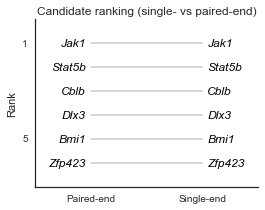

In [2]:
from nbsupport import rank

# Read CTGs.
rna_ctgs = (pd.read_csv('../data/processed/sanger/star-single/ctgs.txt', sep='\t')
              .query('de_pvalue < 0.05'))
rna_ctgs_single = (pd.read_csv('../data/processed/sanger/star-single/ctgs.txt', sep='\t')
                   .query('de_pvalue < 0.05'))

# Compare ranks.
ranks_single = rank.compare_ranks( 
    rna_ctgs.query('de_pvalue < 0.05'),
    rna_ctgs_single.query('de_pvalue < 0.05'),
    suffixes=('_paired', '_single'))

# Plot.
fig, ax = plt.subplots(figsize=(4, 3))
rank.plot_ranks(ranks_single, rank_a='rank_paired', ax=ax,
                rank_b='rank_single', label='gene_name',
                label_kws={'fontstyle': 'italic'})
ax.set_xticklabels(['Paired-end', 'Single-end'])
ax.set_title('Candidate ranking (single- vs paired-end)')

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.2, 1.2)) 
    rank.plot_ranks(ranks_single, rank_a='rank_paired', ax=ax,
                    rank_b='rank_single', label='gene_name',
                    label_kws={'fontstyle': 'italic'})
    ax.set_xticklabels(['Paired-end', 'Single-end'])
    ax.set_title('Candidate ranking (single- vs paired-end)')
    fig.savefig('../reports/figures/fig_5c_single.pdf', bbox_inches='tight')
    plt.close(fig)

In [3]:
# Check number of samples per gene.
pd.merge(rna_ctgs[['gene_name', 'n_samples']],
         rna_ctgs_single[['gene_name', 'n_samples']],
         on='gene_name', suffixes=['_paired', '_single'])

,gene_name,n_samples_paired,n_samples_single
0,Jak1,7,7
1,Stat5b,5,5
2,Cblb,5,5
3,Dlx3,2,2
4,Bmi1,2,2
5,Zfp423,2,2


This shows that both analyses identify the same CTGs, with insertions in the same number of samples.

Finally, by combining the insertion data, we can compare the level of support (in numbers of reads) between the single and paired-end datasets.

In [4]:
# Read insertions.
rna_insertions = (pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
                    .query('support >= 10'))
rna_insertions_single = (pd.read_csv('../data/processed/sanger/star-single/insertions.txt', sep='\t')
                           .query('support >= 10'))

# Summarize for the top genes.
genes = ['Bmi1', 'Cblb', 'Dlx3', 'Jak1', 'Stat5b', 'Zfp423']
support_cols = ['support_junction', 'support_spanning', 'support']

summ_paired = (rna_insertions
 .query('gene_name == {!r}'.format(genes)))

summ_paired = summ_paired.loc[
    summ_paired.groupby(['sample', 'gene_name'])
    ['support'].idxmax()]


summ_single = (rna_insertions_single
 .query('gene_name == {!r}'.format(genes)))

summ_single = summ_single.loc[
    summ_single.groupby(['sample', 'gene_name'])
    ['support'].idxmax()]

# Merge into single overview.
summ_combined = (
    pd.merge(summ_paired[['sample', 'gene_name'] + support_cols], 
            summ_single[['sample', 'gene_name', 'support']],
            on=['sample', 'gene_name'],
            suffixes=('_paired', '_single'), how='outer')
      .sort_values(by=['gene_name', 'support_single'], ascending=[True, False]))

summ_combined = summ_combined[['sample', 'gene_name', 'support_single', 'support_paired',
                              'support_junction', 'support_spanning']]

summ_combined

,sample,gene_name,support_single,support_paired,support_junction,support_spanning
6,TAPJ49_5c,Bmi1,443.0,1714,1714,0
18,TAPJ64_3d,Bmi1,226.0,549,548,1
13,TAPJ53_3m,Cblb,761.0,1286,1029,257
23,TAPJ84_3c,Cblb,374.0,670,523,147
7,TAPJ49_5c,Cblb,334.0,651,515,136
10,TAPJ52_2a,Cblb,272.0,569,441,128
0,TAPJ102_5c,Cblb,232.0,498,380,118
14,TAPJ53_3m,Dlx3,25.0,47,32,15
1,TAPJ102_5c,Dlx3,22.0,26,20,6
4,TAPJ49_1a,Jak1,305.0,522,522,0


This shows that the paired-end data yielded on average two times higher support scores for insertions due to the higher effective depth of paired-end sequencing, and identified a number of insertions that were not detected in the single- end sequencing data.